<h2 style="color:orange" >PROJECT-200: House price prediction using machine
learning algorithm </h2>

$\color{cyan}{\text{Data Collect and Cleaning}}$

In [1]:
#import library..
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Dataset_Bangadesh.csv") #read dataset

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Atrai,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Gournadi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Alfadanga,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Fakirhat,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Banshkhali,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df["area_type"].value_counts() #getting info 

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [6]:
df1=df.drop(['area_type','society','availability', 'balcony' ],axis='columns') #remove some unnessesary columns

In [7]:
df1.head()

,location,size,total_sqft,bath,price
0,Atrai,2 BHK,1056,2.0,39.07
1,Gournadi,4 Bedroom,2600,5.0,120.00
2,Alfadanga,3 BHK,1440,2.0,62.00
3,Fakirhat,3 BHK,1521,3.0,95.00
4,Banshkhali,2 BHK,1200,2.0,51.00


In [8]:
df1.isnull().sum() #Null value

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2=df1.dropna() #remove null value from dataset
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [10]:
df2["size"].unique() 

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df2['bhk'] = df2['size'].apply(lambda x : int(x.split(' ')[0])) #integer only column for BHK

<ipython-input-11-beaa760cca3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk'] = df2['size'].apply(lambda x : int(x.split(' ')[0])) #integer only column for BHK


In [12]:
df2.head(10)

,location,size,total_sqft,bath,price,bhk
0,Atrai,2 BHK,1056,2.0,39.07,2
1,Gournadi,4 Bedroom,2600,5.0,120.00,4
2,Alfadanga,3 BHK,1440,2.0,62.00,3
3,Fakirhat,3 BHK,1521,3.0,95.00,3
4,Banshkhali,2 BHK,1200,2.0,51.00,2
5,Abhaynagar,2 BHK,1170,2.0,38.00,2
6,Chougachha,4 BHK,2732,4.0,204.00,4
7,Atwari,4 BHK,3300,4.0,600.00,4
8,Amtali,3 BHK,1310,3.0,63.25,3
9,Laksam,6 Bedroom,1020,6.0,370.00,6


In [13]:
df2['bhk'].unique() 

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [14]:
df2[df2.bhk > 20] 

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase Ii,27 BHK,8000,27.0,230.0,27
4684,Satkania,43 Bedroom,2400,40.0,660.0,43


In [15]:
df2.total_sqft.unique() #checking incorrect data

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True


In [17]:
df2[~df2['total_sqft'].apply(is_float)].head(15) #check inconsistent data in 'total_sqft'

,location,size,total_sqft,bath,price,bhk
30,Laxmichhari,4 BHK,2100 - 2850,4.0,186.000,4
122,Alikadam,4 BHK,3067 - 8156,4.0,477.000,4
137,Barura,2 BHK,1042 - 1105,2.0,54.005,2
165,Bagher Para,2 BHK,1145 - 1340,2.0,43.490,2
188,Badalgachi,2 BHK,1015 - 1540,2.0,56.800,2
410,Balaganj,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Ashasuni,2 BHK,1195 - 1440,2.0,63.770,2
648,Gowainghat,9 Bedroom,4125Perch,9.0,265.000,9
661,Laxmichhari,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [18]:
def convert_sqft_to_num(x) :
    tokens = x.split('-')
    if len(tokens) == 2 :
        return (float(tokens[0]) + float(tokens[1]))/2
    try :
        return float(x)
    except :
        return None

In [19]:
df3 = df2
df3['total_sqft'] = df3['total_sqft'].apply(convert_sqft_to_num) # making consistent
df3.head(10)

<ipython-input-19-ec4238d613cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['total_sqft'] = df3['total_sqft'].apply(convert_sqft_to_num) # making consistent


,location,size,total_sqft,bath,price,bhk
0,Atrai,2 BHK,1056.0,2.0,39.07,2
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3
3,Fakirhat,3 BHK,1521.0,3.0,95.00,3
4,Banshkhali,2 BHK,1200.0,2.0,51.00,2
5,Abhaynagar,2 BHK,1170.0,2.0,38.00,2
6,Chougachha,4 BHK,2732.0,4.0,204.00,4
7,Atwari,4 BHK,3300.0,4.0,600.00,4
8,Amtali,3 BHK,1310.0,3.0,63.25,3
9,Laksam,6 Bedroom,1020.0,6.0,370.00,6


In [20]:
df4 = df3
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft'] #create new column and count price per squarefeet
df4.head()

<ipython-input-20-81f8cc0b4452>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft'] #create new column and count price per squarefeet


,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Atrai,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Fakirhat,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Banshkhali,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
len(df4.location.unique()) #location number check

1288

In [22]:
df4.location = df4.location.apply(lambda x : x.strip()) #cleaning entries
location_state=df4["location"].value_counts() 
location_state

C:\Users\mahfu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Abhaynagar                534
Adarsha Sadar             392
Aditmari                  302
Agailjhara                266
Ajmiriganj                233
                         ... 
Prasanth Extension          1
Chikka Gowdanapalya.        1
6Th Block Rajaji Nagar      1
1A Block Koramangala        1
Craig Park Layout           1
Name: location, Length: 1285, dtype: int64

In [23]:
len(location_state[location_state <= 10]) #number of occurrences <=10

1050

In [24]:
location_state_less_then_10 = location_state[location_state <= 10] #save smaller occurrences
location_state_less_then_10

Nagadevanahalli           10
Sadashiva Nagar           10
Gunjur Palya              10
Dodsworth Layout          10
Naganathapura             10
                          ..
Prasanth Extension         1
Chikka Gowdanapalya.       1
6Th Block Rajaji Nagar     1
1A Block Koramangala       1
Craig Park Layout          1
Name: location, Length: 1050, dtype: int64

In [25]:
len(df4.location.unique())

1285

In [26]:
#Rename location name(less then 10) to 'other'
df4.location = df4.location.apply(lambda x: 'other' if x in location_state_less_then_10 else x)
len(df4.location.unique())

C:\Users\mahfu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


236

In [27]:
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Atrai,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Gournadi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Alfadanga,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Fakirhat,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Banshkhali,2 BHK,1200.0,2.0,51.00,2,4250.000000


$\color{cyan}{\text{Removing Outliers}}$

In [28]:
df4[df4.total_sqft/df4.bhk < 300].head() #sqft per bhk(less then 300)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,Belabo,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Joypurhat Sadar,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [29]:
df4.shape

(13246, 7)

In [30]:
#Remove some location(bhk < 300)
df5 = df4[~(df4.total_sqft/df4.bhk < 300)]
df5.shape

(12502, 7)

In [31]:
df5.price_per_sqft.describe() #check price per sqft range

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [32]:
#Remove very high or very low properties(price per sqft)
def rmv_pps_outlier(df) :
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location') :
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduce_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)
    return df_out
df6 = rmv_pps_outlier(df5)
df6.shape

(10252, 7)

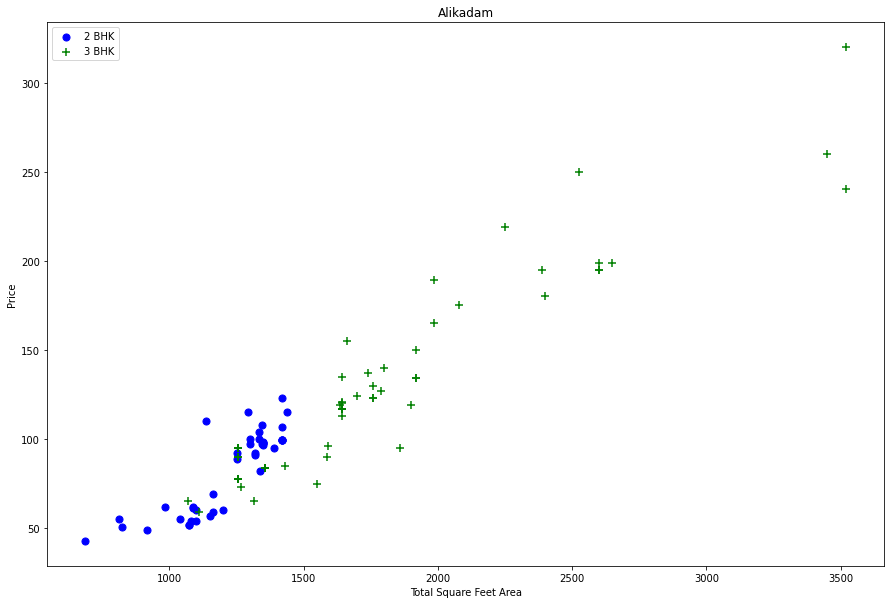

In [33]:
#check pricing abnormalities
def scatter(df, location) :
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK', s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color = 'green', marker = '+', label = '3 BHK', s = 50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
scatter(df6, 'Alikadam')

In [34]:
#remove abnormalities
def rmv_bhk_outlier(df) :
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location') :
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk') :
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk') :
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5 :
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

In [35]:
df7 = rmv_bhk_outlier(df6)
df7.shape

(7324, 7)

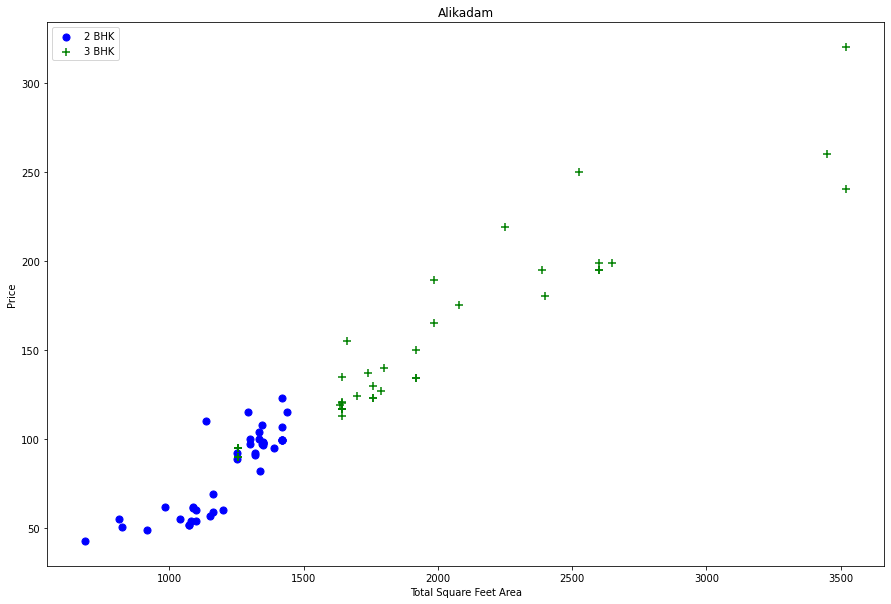

In [36]:
scatter(df7, 'Alikadam')

Text(0, 0.5, 'Count')

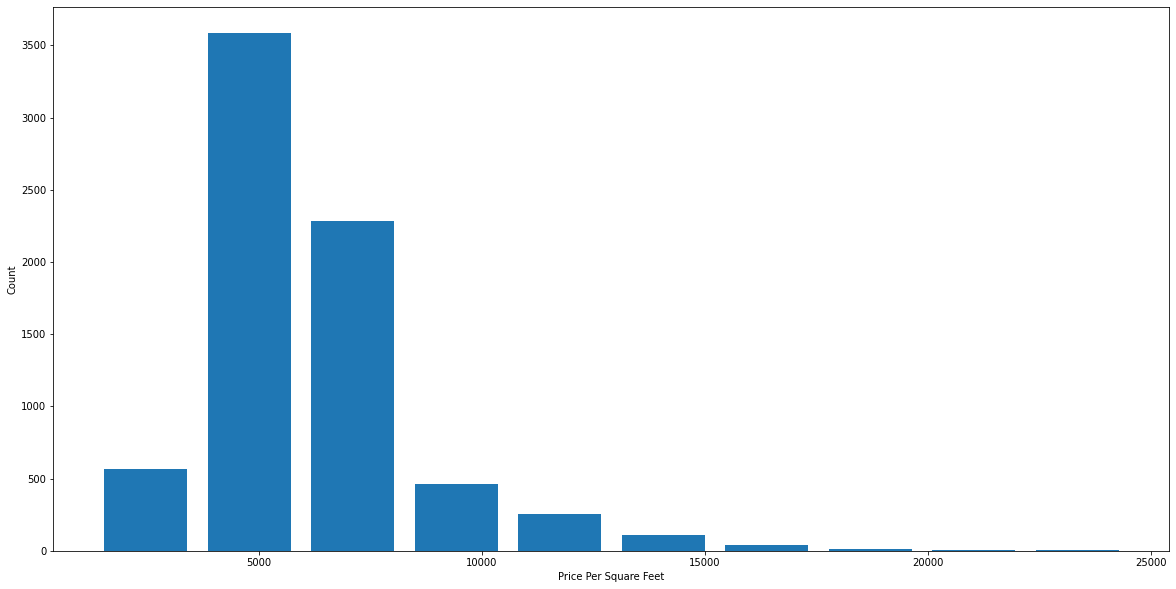

In [37]:
#checking distribution
matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.hist(df7.price_per_sqft, rwidth = 0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')

In [38]:
df7.bath.unique()

array([ 3.,  2.,  4.,  5.,  1.,  6.,  7.,  8.,  9., 12., 16., 13.])

In [39]:
df7[df7.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
7846,Magura Sadar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8489,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8578,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9317,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9649,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

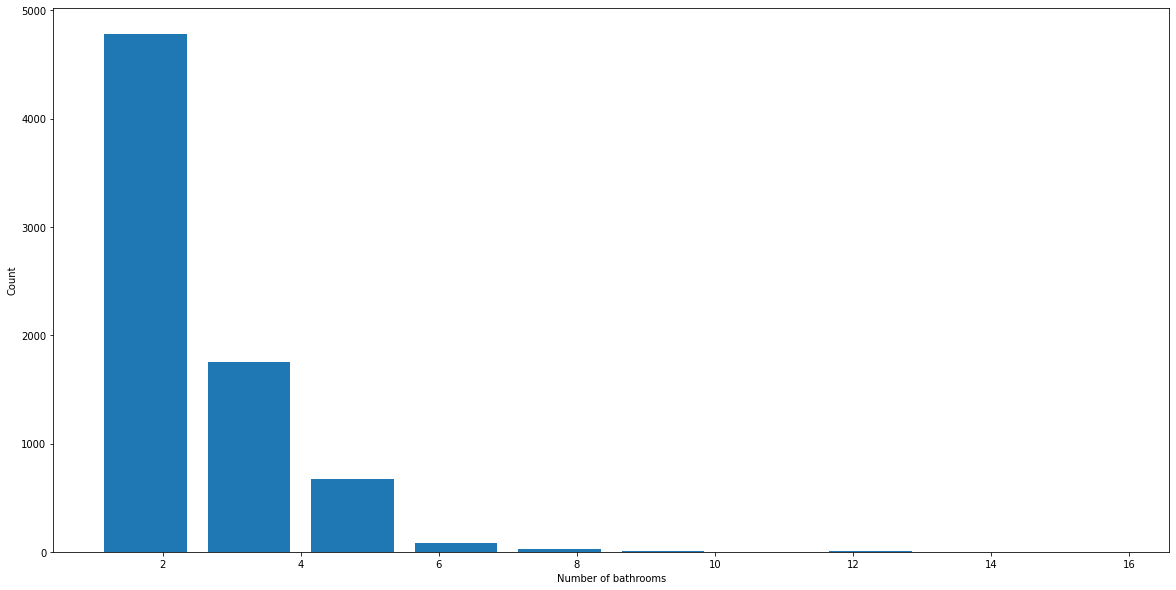

In [40]:
plt.hist(df7.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [41]:
#removing excess bathrooms
df7[df7.bath > df7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1380,Ajmiriganj,3 BHK,1806.0,6.0,116.0,3,6423.034330
7454,Kamarkhand,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
7578,Khaliajuri,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
8413,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [42]:
#removing excess bathrooms
df8 = df7[df7.bath < df7.bhk+2]
df8.shape

(7248, 7)

In [43]:
#removing unnecessary column 
df9 = df8.drop(['size', 'price_per_sqft'], axis = 'columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
2,Abhaynagar,1610.0,3.0,81.00,3
3,Abhaynagar,1459.0,2.0,94.82,2
8,Abhaynagar,1280.0,2.0,75.00,2


$\color{cyan}{\text{Machine Learning Model Building}}$

In [44]:
dumies = pd.get_dummies(df9.location)
dumies.head(3)

,Abhaynagar,Adarsha Sadar,Aditmari,Agailjhara,Ajmiriganj,Alfadanga,Alikadam,Amtali,Anwara,Araihazar,...,Laxmichhari,Magura Sadar,Mirsharai,Nikli,Pekua,Porsha,Satkania,Titas,Ukhia,other
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df10 = pd.concat([df9, dumies.drop('other', axis='columns')], axis = 'columns')
df10.head(3)

,location,total_sqft,bath,price,bhk,Abhaynagar,Adarsha Sadar,Aditmari,Agailjhara,Ajmiriganj,...,Kushtia Sadar,Laxmichhari,Magura Sadar,Mirsharai,Nikli,Pekua,Porsha,Satkania,Titas,Ukhia
2,Abhaynagar,1610.0,3.0,81.00,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abhaynagar,1459.0,2.0,94.82,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Abhaynagar,1280.0,2.0,75.00,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df11 = df10.drop('location', axis = 'columns')
df11.head(3)

,total_sqft,bath,price,bhk,Abhaynagar,Adarsha Sadar,Aditmari,Agailjhara,Ajmiriganj,Alfadanga,...,Kushtia Sadar,Laxmichhari,Magura Sadar,Mirsharai,Nikli,Pekua,Porsha,Satkania,Titas,Ukhia
2,1610.0,3.0,81.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1459.0,2.0,94.82,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1280.0,2.0,75.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X = df11.drop(['price'], axis = 'columns')
X.head()

,total_sqft,bath,bhk,Abhaynagar,Adarsha Sadar,Aditmari,Agailjhara,Ajmiriganj,Alfadanga,Alikadam,...,Kushtia Sadar,Laxmichhari,Magura Sadar,Mirsharai,Nikli,Pekua,Porsha,Satkania,Titas,Ukhia
2,1610.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1459.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1280.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1910.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,3252.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
y=df11.price
y.head()

2      81.00
3      94.82
8      75.00
10    161.00
11    230.00
Name: price, dtype: float64

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [50]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8020367879426851

In [51]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.79076262, 0.83416384, 0.87538461, 0.80509727, 0.83611907])

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def find_best_model_using_gridsearchcv(X,y):
    algos={
        'linear_regression':{
            'model':LinearRegression(),
            'params':{
                'normalize':[True, False]
                }
        },
        'lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion' :['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores =[]
    cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
            })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.828305,{'normalize': False}
1,lasso,0.705278,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.705133,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [53]:
X.columns

Index(['total_sqft', 'bath', 'bhk', 'Abhaynagar', 'Adarsha Sadar', 'Aditmari',
       'Agailjhara', 'Ajmiriganj', 'Alfadanga', 'Alikadam',
       ...
       'Kushtia Sadar', 'Laxmichhari', 'Magura Sadar', 'Mirsharai', 'Nikli',
       'Pekua', 'Porsha', 'Satkania', 'Titas', 'Ukhia'],
      dtype='object', length=238)

In [54]:
def predict_price(location,sqft,bath,bhk):    
    loc_index=np.where(X.columns==location)[0][0]
    x=np.zeros(len(X.columns))
    x[0]=sqft
    x[1]=bath
    x[2]=bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr_clf.predict([x])[0]

In [55]:
predict_price('Kishoreganj', 1600, 3,3)

96.46837001989967

In [57]:
import pickle
with open("Bangladesh_home_price.pickle","wb") as f:
    pickle.dump(lr_clf,f)

In [58]:
import json
columns={
    "data_columns": [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))